In [1]:
import numpy as np
np.random.seed(19906)
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
import cv2
import os
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2

Using TensorFlow backend.


使用Xception模型

In [2]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [3]:
train_dir = "data/imgs/train2"
val_dir = "data/imgs/val2"
test_dir = "data/imgs/test1"
saved_weights = "saved_weights"
if not os.path.exists(saved_weights):
    os.mkdir(saved_weights)

In [4]:
def get_im_cv2(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

图片预处理

In [5]:
# 图像生成器输出的图像大小
out_image_size = (299, 299)
batch_size = 32

In [6]:
# 训练集图像生成器
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    rescale=1./255
)

# 验证集图像生成器
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

Found 41850 images belonging to 10 classes.
Found 1399 images belonging to 10 classes.


构建模型

In [7]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax', use_bias=False, kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions, name=base_model.name)

op = Adam(lr=0.00005, decay=2e-8)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

219062272/219055592 [==============================] - 2s 0us/step


开始训练

In [8]:
# 训练代数
epochs = 20

save_file = saved_weights + '/' + model.name + '_model.h5'
print("model name:", model.name, ", will save weight file:", save_file)
callbacks = [
    ModelCheckpoint(save_file, monitor="val_loss", mode="min", save_best_only=True, verbose=1, period=1),
    EarlyStopping(monitor="val_loss", verbose=1, mode="min", min_delta=0.0005, patience=2)
]

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_generator)

model name: inception_resnet_v2 , will save weight file: saved_weights/inception_resnet_v2_model.h5
Epoch 1/20
1308/1308 [==============================] - 1263s 965ms/step - loss: 0.3870 - acc: 0.9350 - val_loss: 0.3092 - val_acc: 0.9485

Epoch 00001: val_loss improved from inf to 0.30917, saving model to saved_weights/inception_resnet_v2_model.h5
Epoch 2/20
1308/1308 [==============================] - 1185s 906ms/step - loss: 0.1395 - acc: 0.9942 - val_loss: 0.2685 - val_acc: 0.9414

Epoch 00002: val_loss improved from 0.30917 to 0.26853, saving model to saved_weights/inception_resnet_v2_model.h5
Epoch 3/20
1308/1308 [==============================] - 1155s 883ms/step - loss: 0.0777 - acc: 0.9969 - val_loss: 0.1460 - val_acc: 0.9700

Epoch 00003: val_loss improved from 0.26853 to 0.14600, saving model to saved_weights/inception_resnet_v2_model.h5
Epoch 4/20
1308/1308 [==============================] - 1165s 891ms/step - loss: 0.0520 - acc: 0.9960 - val_loss: 0.1650 - val_acc: 0.9543


绘制图型

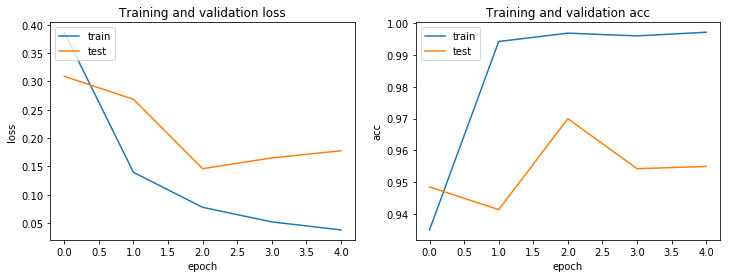

In [9]:
# 绘制图型
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

测试预测结果

In [10]:
from keras.models import load_model

pred_model = load_model("saved_weights/inception_resnet_v2_model.h5")

预测所有测试集，并生成提交kaggle的报告

In [11]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
pred_batch_size=128

test_generator = test_datagen.flow_from_directory(test_dir, out_image_size, shuffle=False, 
                                             batch_size=pred_batch_size, class_mode=None)

test_generator.filenames[0]

Found 79726 images belonging to 1 classes.


'test/img_1.jpg'

In [12]:
sub_df = pd.read_csv("data/sample_submission.csv")

y_preds = pred_model.predict_generator(test_generator, verbose=1)
y_preds = y_preds.clip(min=0.005, max=0.995)
print("y_pred shape {}".format(y_preds.shape))

for i, fname in enumerate(test_generator.filenames):
    y_pred = y_preds[i]
    for k, c in enumerate(y_pred):
        sub_df.at[i, 'c'+str(k)] = c

print(sub_df.head())

sub_df.to_csv('data/pred.csv', index=None)
print("predict done.")

623/623 [==============================] - 583s 936ms/step
y_pred shape (79726, 10)
              img        c0        c1        c2        c3        c4       c5  \
0       img_1.jpg  0.005000  0.005000  0.005000  0.005000  0.005000  0.99500   
1      img_10.jpg  0.005000  0.005000  0.005000  0.005000  0.005000  0.99500   
2     img_100.jpg  0.375924  0.006485  0.006275  0.005579  0.007222  0.01189   
3    img_1000.jpg  0.005000  0.005000  0.075646  0.005000  0.005000  0.00500   
4  img_100000.jpg  0.005000  0.005000  0.005000  0.994039  0.005000  0.00500   

      c6     c7        c8        c9  
0  0.005  0.005  0.005000  0.005000  
1  0.005  0.005  0.005000  0.005000  
2  0.005  0.005  0.496935  0.082455  
3  0.005  0.005  0.903965  0.006955  
4  0.005  0.005  0.005000  0.005000  
predict done.


提交到kaggle中后得到成绩：private:  0.29201, public: 0.35846